In [0]:
import geoanalytics
geoanalytics.version()

Out[3]: '1.1.0.808'

In [0]:
# Sign in if you have a prepaid plan
geoanalytics.auth(username="myuser", password="mypassword")

In [0]:
from geoanalytics.sql import functions as ST

spark.sql("show user functions like 'ST_*'").show(150)

+--------------------+
|            function|
+--------------------+
|  st_aggr_convexhull|
|st_aggr_intersection|
|  st_aggr_meancenter|
|st_aggr_stdevellipse|
|       st_aggr_union|
|             st_area|
|         st_asbinary|
|       st_asesrijson|
|        st_asgeojson|
|          st_asshape|
|           st_astext|
|          st_azimuth|
|        st_bincenter|
|      st_bingeometry|
|            st_binid|
|         st_boundary|
|           st_buffer|
|             st_cast|
|         st_centroid|
|     st_closestpoint|
|         st_contains|
|       st_convexhull|
|         st_coorddim|
|          st_crosses|
|          st_densify|
|       st_difference|
|        st_dimension|
|         st_disjoint|
|         st_distance|
|          st_dwithin|
|         st_endpoint|
|         st_envelope|
|    st_envintersects|
|           st_equals|
|     st_exteriorring|
|       st_generalize|
|     st_geodesicarea|
|   st_geodesicbuffer|
|st_geodesiccloses...|
|  st_geodesicdensify|
| st_geodes

#### Loading and Saving Spatial Data

In [0]:
bus_stops = spark.read.format("csv") \
                 .option("header", True) \
                 .option("inferSchema", True) \
                 .load("/FileStore/NY_Bus_Stops")
bus_stops.printSchema()

root
 |-- LOCATION: string (nullable = true)
 |-- SHELTER_ID: string (nullable = true)
 |-- the_geom: string (nullable = true)
 |-- AT_BETWEEN: string (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LATITUDE: double (nullable = true)



In [0]:
bus_stop_points = bus_stops.withColumn("point", ST.point("LONGITUDE", "LATITUDE", 4326))
bus_stop_points.show(5)
bus_stop_points.printSchema()

+-------------+----------+--------------------+----------+----------+---------+--------------------+
|     LOCATION|SHELTER_ID|            the_geom|AT_BETWEEN| LONGITUDE| LATITUDE|               point|
+-------------+----------+--------------------+----------+----------+---------+--------------------+
|  MONTROSE AV|    BR0003|POINT (-73.947831...|LORIMER ST|-73.947831|40.706812|{"x":-73.947831,"...|
|    GRAHAM AV|    BR0014|POINT (-73.945162...|HERBERT ST|-73.945162|40.719097|{"x":-73.945162,"...|
|     BROADWAY|    BR0026|POINT (-73.945783...|LEONARD ST|-73.945783|40.702976|{"x":-73.945783,"...|
| KINGSLAND AV|    BR0028|POINT (-73.940836...|HERBERT ST|-73.940836|40.720195|{"x":-73.940836,"...|
|VANDERBILT AV|    BR0040|POINT (-73.969795...| MYRTLE AV|-73.969795| 40.69344|{"x":-73.969795,"...|
+-------------+----------+--------------------+----------+----------+---------+--------------------+
only showing top 5 rows



In [0]:
subway_stops = spark.read.format("csv") \
                 .option("header", True) \
                 .option("inferSchema", True) \
                 .load("/FileStore/NY_Subway_Stations/") \
                 .withColumn("point", ST.point_from_text("the_geom", 4326))

subway_stops.show(5)

+--------+--------------------+--------------------+--------------------+----+--------------------+
|OBJECTID|                 URL|                NAME|            the_geom|LINE|               point|
+--------+--------------------+--------------------+--------------------+----+--------------------+
|    1734|http://web.mta.in...|Birchall Ave & Sa...|POINT (-73.868356...| 2-5|{"x":-73.86835600...|
|    1735|http://web.mta.in...|Birchall Ave & Sa...|POINT (-73.868213...| 2-5|{"x":-73.86821300...|
|    1736|http://web.mta.in...|Morris Park Ave &...|POINT (-73.873499...| 2-5|{"x":-73.87349900...|
|    1737|http://web.mta.in...|Morris Park Ave &...|POINT (-73.872891...| 2-5|{"x":-73.87289199...|
|    1738|http://web.mta.in...|Boston Rd & 178th...|POINT (-73.879623...| 2-5|{"x":-73.87962300...|
+--------+--------------------+--------------------+--------------------+----+--------------------+
only showing top 5 rows



#### Spatial Data Sources Included in GeoAnalytics Engine:
- Feature Service
- Shapefile
- GeoJSON
- GeoParquet
- Vector Tiles (write points only)

In [0]:
boroughs_url = "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0"
boroughs = spark.read.format("feature-service").load(boroughs_url)

boroughs.printSchema()

root
 |-- OBJECTID: long (nullable = false)
 |-- BoroCode: short (nullable = true)
 |-- BoroName: string (nullable = true)
 |-- Shape__Area: double (nullable = true)
 |-- Shape__Length: double (nullable = true)
 |-- shape: polygon (nullable = true)



In [0]:
spark.read.format("feature-service").load(boroughs_url).filter("BoroName == 'Brooklyn'").explain()

== Physical Plan ==
*(1) Project [OBJECTID#285L, BoroCode#286, BoroName#287, Shape__Area#288, Shape__Length#289, shape#290]
+- BatchScan NYC_Borough_Boundary[OBJECTID#285L, BoroCode#286, BoroName#287, Shape__Area#288, Shape__Length#289, shape#290] FeatureServiceLayerScan[f=json, query="returnM=true&outFields=OBJECTID,BoroCode,BoroName,Shape__Area,Shape__Length&where=(BoroName IS NOT NULL AND (BoroName = 'Brooklyn'))&returnZ=true", paging=oid-range(field=OBJECTID,size=5,count=1)] RuntimeFilters: []




#### Plotting

In [0]:
# Transform all data into the same spatial reference
subway_stops_2263 = subway_stops.withColumn("point", ST.transform("point", 2263))
bus_stops_2263 = bus_stop_points.withColumn("point", ST.transform("point", 2263))

Out[26]: <AxesSubplot:>

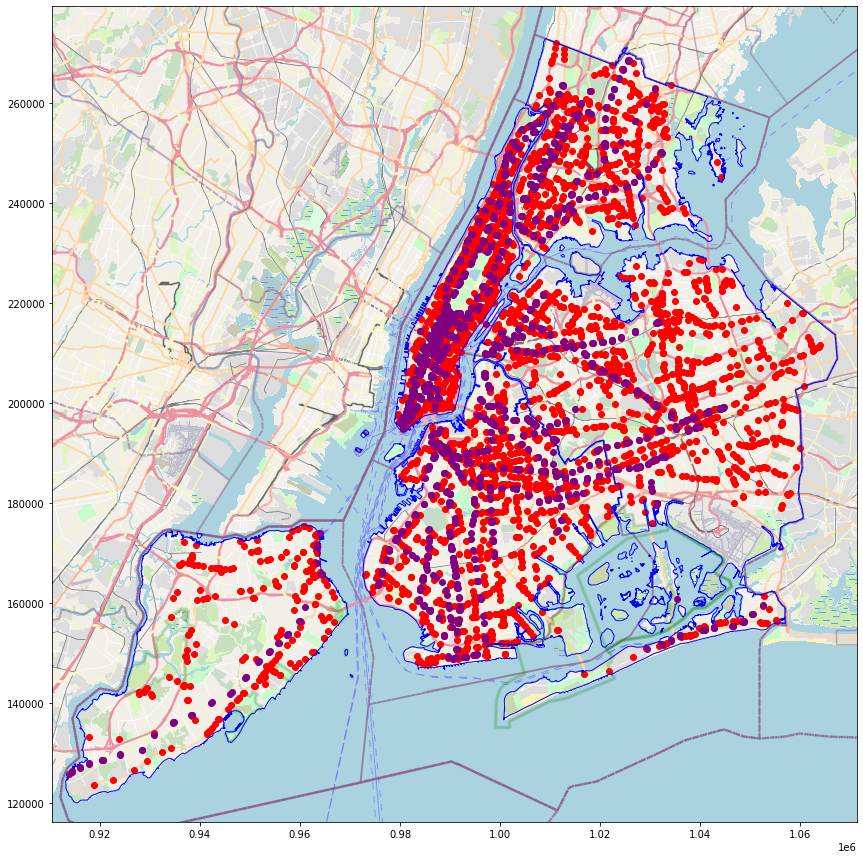

In [0]:
ax = bus_stops_2263.st.plot(basemap="osm", figsize=(15,15), aspect="equal", facecolor="red")

boroughs.st.plot(ax=ax, edgecolor="blue", facecolor="none")

subway_stops_2263.st.plot(ax=ax, facecolor="purple")

#### Tools

In [0]:
from geoanalytics.tools import *

- Aggregate points
- Calculate density
- Calculate field
- Calculate motion statistics
- Clip
- Detect incidents
- Find dwell locations
- Find hot spots
- Find point clusters
- Find similar locations
- Geographically weighted regression
- Group by proximity
- Nearest neighbors
- Overlay
- Reconstruct tracks
- Snap tracks
- Spatiotemporal join
- Summarize within
- Trace proximity events

##### Group By Proximity
<img src =' /files/jars/gbp_workflow.png'>

Out[30]: <AxesSubplot:>

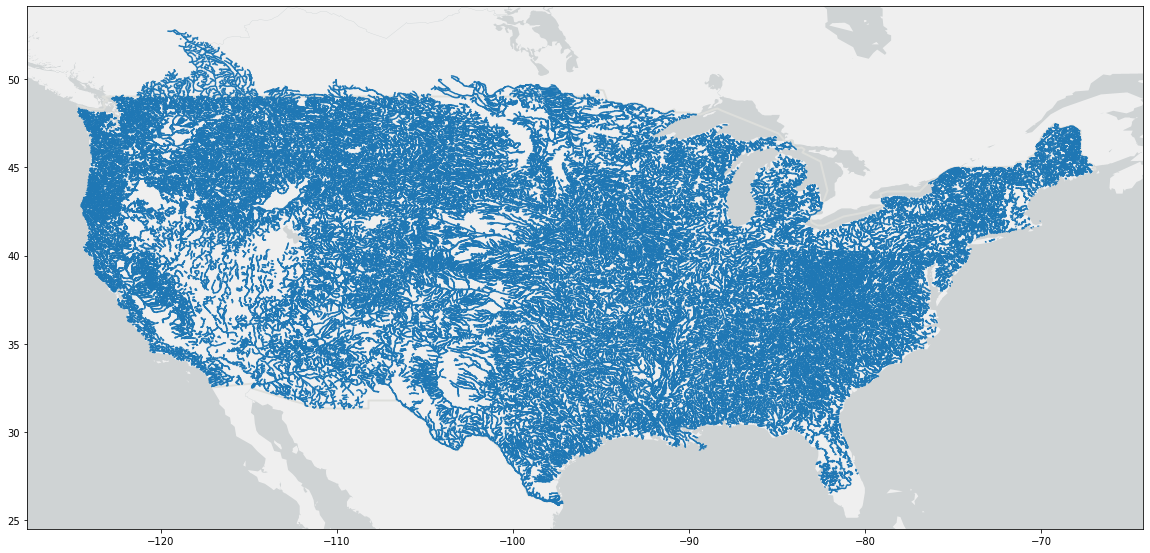

In [0]:
# Load US river lines
rivers = spark.read.format("shapefile").load("dbfs:/FileStore/rivers").select("geometry")
rivers.st.plot(figsize=(20,20), basemap="light")

In [0]:
# Set up tool
grouper = tools.GroupByProximity() \
               .setSpatialRelationship("Touches")

In [0]:
# Run tool?
grouped_rivers = grouper.run(rivers)

In [0]:
# Run tool and plot
grouped_rivers.st.plot(geometry="geometry", figsize=(20,20), basemap="light",
                       is_categorical=True, cmap_values="GROUP_ID", cmap="prism")

Out[33]: <AxesSubplot:>

#### Saving Data

In [0]:
# Write a feature service to ArcGIS Online

geoanalytics.register_gis(name="myGIS", username="NSlocum_GDBteam", password="")

grouped_rivers.write.format("feature-service").option("gis", "myGIS").save("test_rivers_001")

In [0]:
# Write to shapefile

grouped_rivers.coalesce(1).write.format("shapefile").save("dbfs:/FileStore/test001")

In [0]:
# Write to geoparquet

grouped_rivers.write.format("geoparquet").save("s3a:/testBucket/test002")

In [0]:
# Write to CSV

grouped_rivers.withColumn("wkt", ST.as_text("geometry")) \
              .drop("geometry") \
              .write \
              .csv("dbfs:/FileStore/test003")

##### An incomplete list of Spark data sources and connectors:
- Parquet
- ORC
- JSON
- CSV
- Hive
- Avro
- DB2
- MariaDB
- MS Sql
- Oracle
- PostgreSQL
- SAS
- MongoDB
- Neo4j
- AWS S3
- Azure Data Lake
- Azure Blob
- Amazon Redshift
- Cassandra
- Snowflake
- BigQuery
- HBase

#### Putting it all together

Blog: [ArcGIS GeoAnalytics Engine in Databricks: 
Scalable Geospatial Analysis in a Data Science Workflow](https://www.databricks.com/blog/2022/12/07/arcgis-geoanalytics-engine-databricks.html)

<img src =' /files/qr_code-1.png'  width="200" height="200">